In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()

## Read data

In [2]:
df_master = pd.read_csv('14-06-2022/master.csv')
df_master['branch'] = 'master'

df_new = pd.read_csv('14-06-2022/new-algorithm-d10us.csv')
df_new['branch'] = 'new-algorithm-d10us'

df = pd.concat([df_master, df_new], ignore_index = True)
df.sample(10)

,name,cpu_time_us,package_energy,core_energy,branch
192,Life - sequential generation,54748,370342,6942,master
699,Travelling Salesman Problem,4762,15151,2594,new-algorithm-d10us
884,Life - parallel bridge generation,5576472,5062559,660747,new-algorithm-d10us
124,Life - parallel bridge generation,5507214,5207494,634611,master
645,NBody parallel iterator,35683,98353,18188,new-algorithm-d10us
39,Travelling Salesman Problem,8394,14800,595,master
89,Travelling Salesman Problem,6939,15578,2075,master
946,NBody parallel reduce,156472,261065,46811,new-algorithm-d10us
50,MergeSort,16515113,19156312,1967717,master
760,MergeSort,19443519,17843987,3521806,new-algorithm-d10us


## Remove outliers

In [3]:
q_low = df["cpu_time_us"].quantile(0.01)
q_hi  = df["cpu_time_us"].quantile(0.99)
df = df[(df["cpu_time_us"] < q_hi) & (df["cpu_time_us"] > q_low)]

q_low = df["package_energy"].quantile(0.01)
q_hi  = df["package_energy"].quantile(0.99)
df = df[(df["package_energy"] < q_hi) & (df["package_energy"] > q_low)]

q_low = df["core_energy"].quantile(0.01)
q_hi  = df["core_energy"].quantile(0.99)
df = df[(df["core_energy"] < q_hi) & (df["core_energy"] > q_low)]

## Normalize data

In [4]:
def extract_means(input_df):
    means = {'name': [],
             'branch': [],
             'cpu_time_us': [],
             'core_energy': [],
             'package_energy': []}

    for algorithm in set(input_df['name']):
        algorithm_df = input_df[input_df['name'] == algorithm]
        means['name'].append(algorithm)
        means['branch'].append(algorithm_df['branch'].values[0])
        means['cpu_time_us'].append(algorithm_df['cpu_time_us'].mean())
        means['core_energy'].append(algorithm_df['core_energy'].mean())
        means['package_energy'].append(algorithm_df['package_energy'].mean())
    
    return means


master_dict = extract_means(df_master)
new_algorithm_dict = extract_means(df_new)
means = {'name': [], 
         'cpu_time_ratio': [],
         'core_energy_ratio': [],
         'package_energy_ratio': []}

for index, algorithm in enumerate(master_dict['name']):
    means['name'].append(algorithm)
    means['cpu_time_ratio'].append(master_dict['cpu_time_us'][index] / new_algorithm_dict['cpu_time_us'][index])
    means['core_energy_ratio'].append(master_dict['core_energy'][index] / new_algorithm_dict['core_energy'][index])
    means['package_energy_ratio'].append(master_dict['package_energy'][index] / new_algorithm_dict['package_energy'][index])

df_to_plot = pd.DataFrame(data=means)
df_to_plot = df_to_plot.sort_values('cpu_time_ratio', ascending = False)
display(df_to_plot)


,name,cpu_time_ratio,core_energy_ratio,package_energy_ratio
2,NBody parallel iterator,1.263844,0.985276,0.935696
6,Travelling Salesman Problem,1.255194,0.942473,0.974067
5,NBody parallel reduce,0.996735,0.970377,0.974965
0,Life - parallel bridge generation,0.984393,1.022166,1.022019
3,FrogJump,0.935320,0.724915,0.792499
1,QuickSort,0.889378,1.016067,0.926230
8,MergeSort,0.880423,0.778532,0.922796
9,Life - parallel iterators generation,0.855778,0.881462,0.877666
4,Life - sequential generation,0.408181,0.909678,0.671045
7,NBody sequential,0.389056,0.996835,0.677034


## CPU time

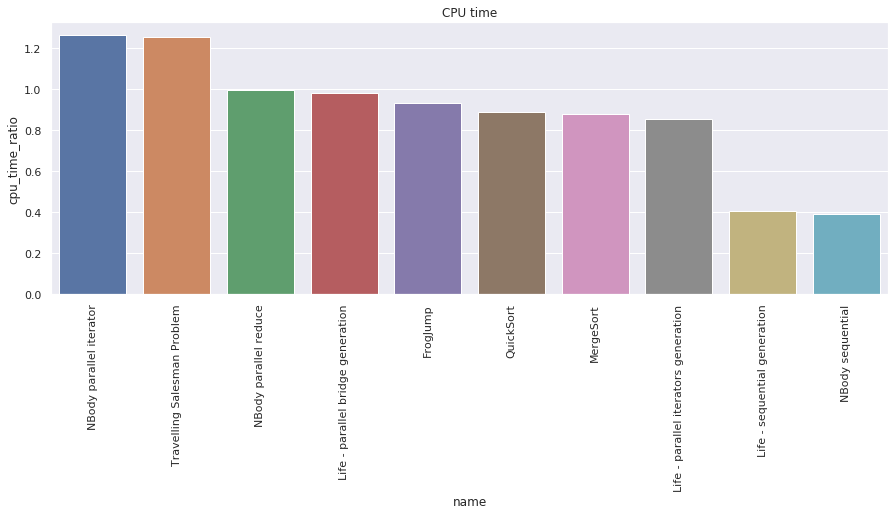

In [5]:
fig1, ax1 = plt.subplots(figsize=(15,5))
ax1.set_title('CPU time')
ax1.set_ylabel('Active time [us]')
ax1.set_xlabel('Algorithm')

#sns.barplot(x='name', y='cpu_time_us', hue='branch', data=df_to_plot);
sns.barplot(x='name', y='cpu_time_ratio', data=df_to_plot);
plt.xticks(rotation=90);

# x = mean(master) / mean(new_algorithm)
#     x < 1: we are losing
#     x > 1: we are winning

## Energy

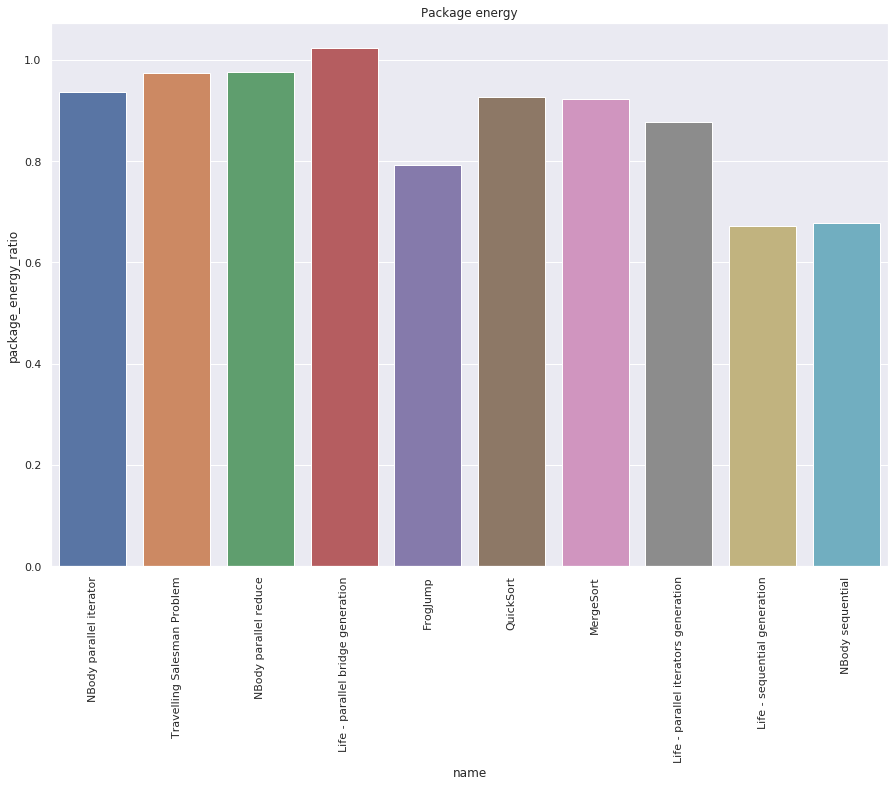

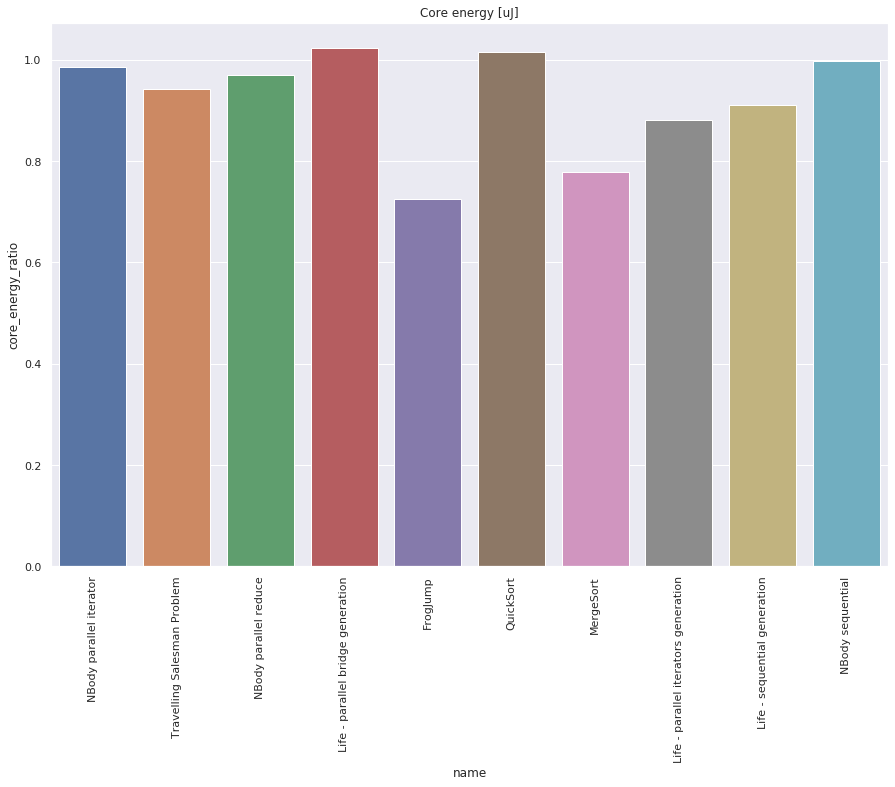

In [6]:
fig2, ax2 = plt.subplots(1, figsize=(15, 10));

ax2.set_title('Package energy')
ax2.set_ylabel('Energy [uJ]')
ax2.set_xlabel('Sleep duration [us]')
sns.barplot(x='name', y='package_energy_ratio', data=df_to_plot);
plt.xticks(rotation=90);

fig2, ax3 = plt.subplots(1, figsize=(15, 10));

ax3.set_title('Core energy [uJ]')
ax3.set_ylabel('Energy [uJ]')
ax3.set_xlabel('Sleep duration [us]')
sns.barplot(x='name', y='core_energy_ratio', data=df_to_plot);

plt.xticks(rotation=90);

## Histogram

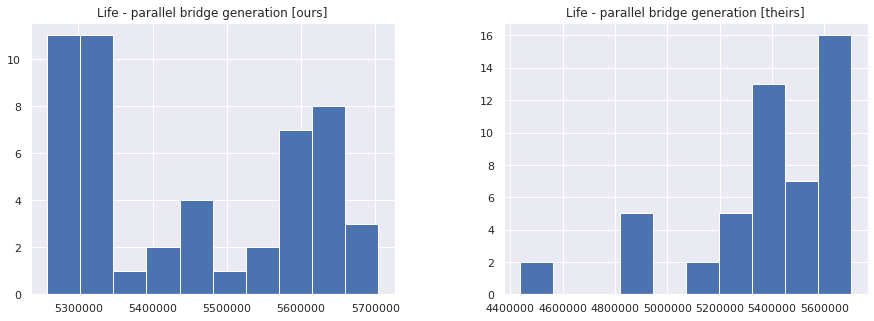

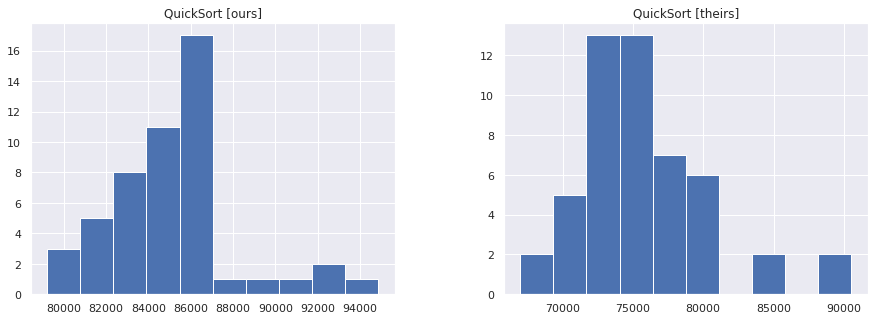

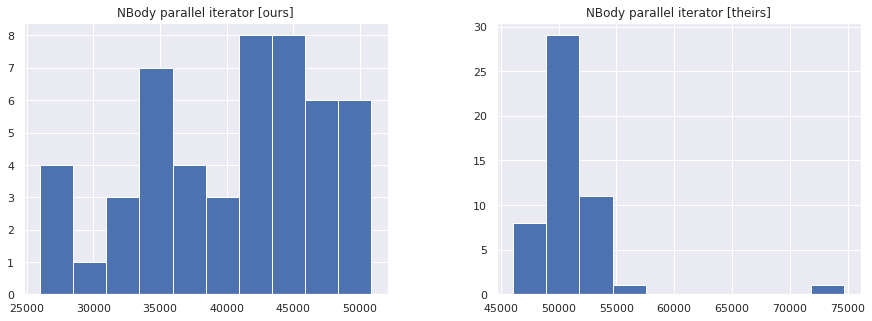

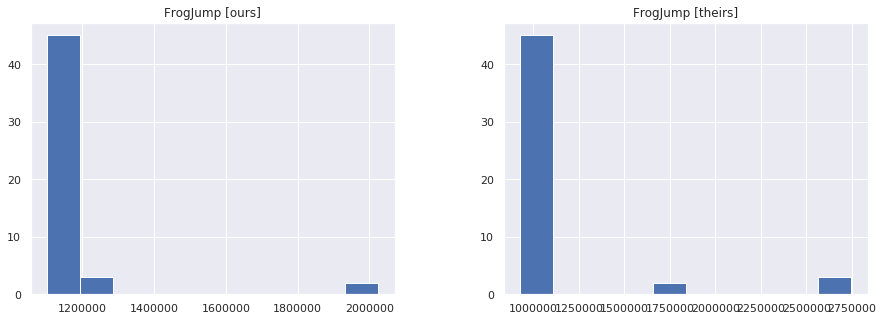

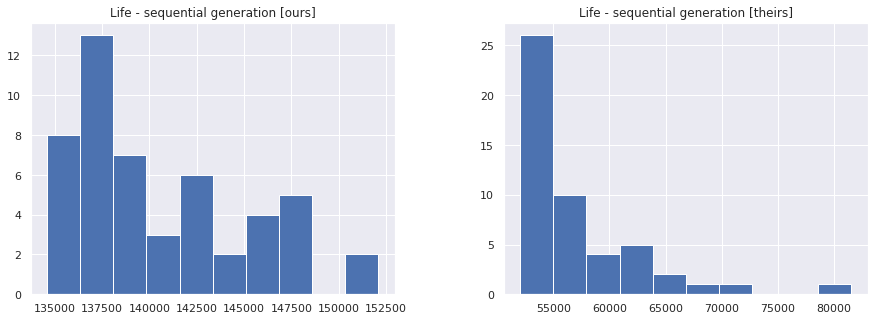

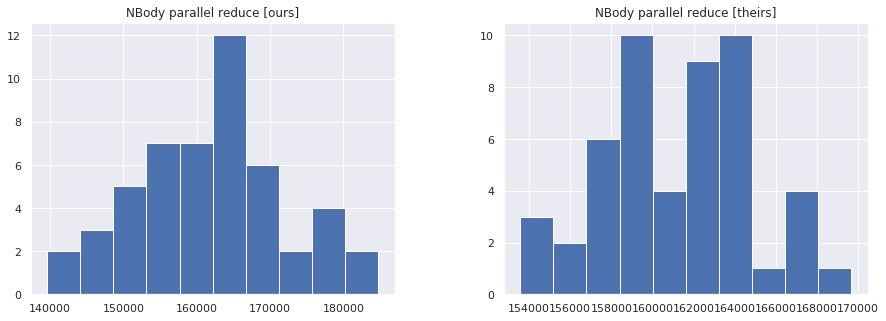

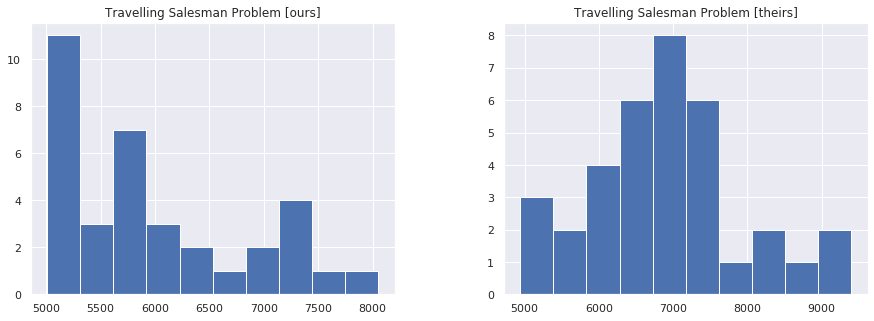

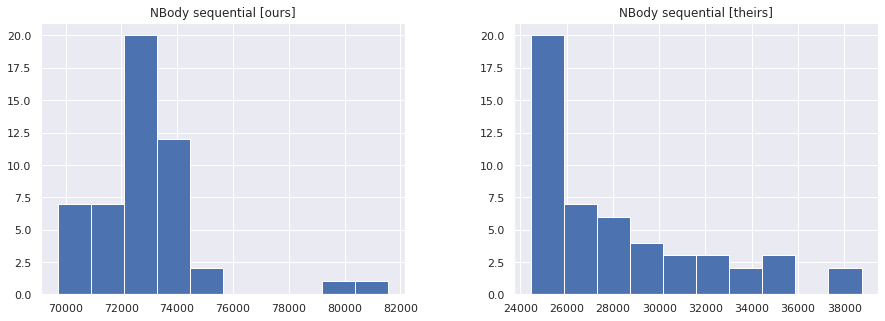

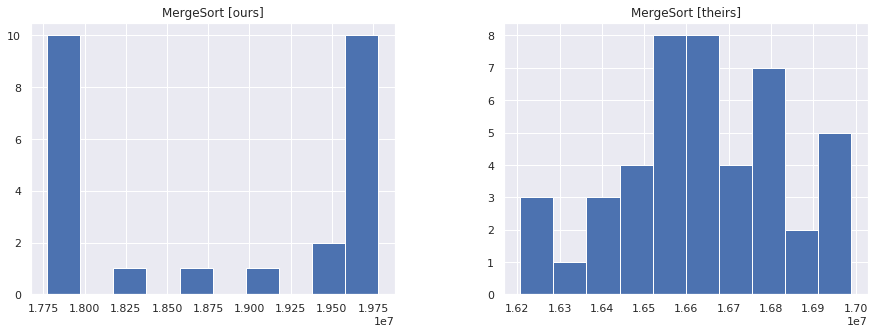

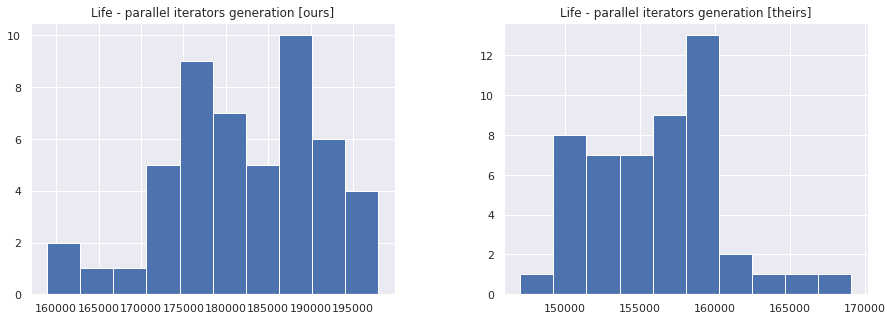

In [7]:
ours = df[df['branch'] != 'master']
theirs = df[df['branch'] == 'master']

for algorithm in set(df['name']):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    our_algorithm_df = ours[ours['name'] == algorithm]
    their_algorithm_df = theirs[theirs['name'] == algorithm]

    our_hist = our_algorithm_df.hist(bins=10, column='cpu_time_us', ax=ax1)
    their_hist = their_algorithm_df.hist(bins=10, column='cpu_time_us', ax=ax2)
    ax1.set_title(algorithm + ' [ours]')
    ax2.set_title(algorithm + ' [theirs]')